In [1]:
import netCDF4 as nc
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import os,sys,fnmatch,time
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib import animation
from salishsea_tools.nc_tools import scDataset
from salishsea_tools import (psu_tools, teos_tools)
from matplotlib import colors
from matplotlib import ticker
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LightSource
import time
from datetime import datetime 
import gsw
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation')
import general_functions
import quicklook
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/upwelling_depth/')
import upwelling_functions

import warnings
warnings.filterwarnings("ignore")

/home/imachuca/anaconda3/envs/gsw/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


# Functions

In [2]:
def get_vars_surf(dirname, fname, meshmaskname, time_ind):
    
    y,x = slice(1,-1,None), slice(1,-1,None)
    
    filesT = general_functions.get_files(dirname, fname, 'grid_T')
    filesU = general_functions.get_files(dirname, fname, 'grid_U') 
    filesV = general_functions.get_files(dirname, fname, 'grid_V')
    filesW = general_functions.get_files(dirname, fname, 'grid_W')
            
    with scDataset(filesT) as dsT, scDataset(filesU) as dsU, scDataset(filesV) as dsV, scDataset(filesW) as dsW:
        vosaline0 = dsT.variables['vosaline'][time_ind, :, y, x]
        votemper0 = dsT.variables['votemper'][time_ind, :, y, x]
        vozocrtx0 = dsU.variables['vozocrtx'][time_ind, :, y, x]
        vomecrty0 = dsV.variables['vomecrty'][time_ind, :, y, x]
        vovecrtz0 = dsW.variables['vovecrtz'][time_ind, :, y, x]
        deptht = dsT.variables['deptht'][:]
        
    with nc.Dataset(os.path.join(dirname, meshmaskname), 'r') as dsM:
        tmask = dsM.variables['tmask'][0, :, y, x]
        mbathy = dsM.variables['mbathy'][0, y, x]

    vosaline = np.ma.array(vosaline0, mask=1 - tmask)
    votemper = np.ma.array(votemper0, mask=1 - tmask)
    vozocrtx = np.ma.array(vozocrtx0, mask=1 - tmask)
    vomecrty = np.ma.array(vomecrty0, mask=1 - tmask)
    vovecrtz = np.ma.array(vovecrtz0, mask=1 - tmask)
    
    ideal_file = nc.Dataset(dirname+'1_ideal_bathy_for_agrif.nc')
    ideal = ideal_file['Bathymetry'][y, x]
    
    return vosaline, votemper, vozocrtx, vomecrty, vovecrtz, tmask, mbathy, deptht, ideal

In [3]:
def calculate_density(vosaline, votemper):
    sigma = np.full([vosaline.shape[-3], vosaline.shape[-2], vosaline.shape[-1]], np.nan)
    for k in range(vosaline.shape[-3]):
        gsw_vosaline = vosaline[k, :, :]
        gsw_votemper = votemper[k, :, :]
        sigma[k, :, :] = gsw.rho(gsw_vosaline, gsw_votemper, 0) - 1000
    return sigma

In [4]:
def make_density_surface(density_value, sigma, mbathy, var):

    xs = np.arange(sigma.shape[-1])
    ys = np.arange(sigma.shape[-2])

    surf_depth = np.zeros([len(ys), len(xs)])
    surf_var = np.zeros_like(surf_depth)

    for j in range(len(ys)):
        for i in range(len(xs)):
            if mbathy[j, i] > 0:
                column_sigma = sigma[:mbathy[j, i], j, i]
                column_var = var[:mbathy[j, i], j, i]
                column_depth = deptht[:mbathy[j, i]]

                surf_depth[j, i] = np.interp(density_value, column_sigma, column_depth)
                surf_var[j, i] = np.interp(surf_depth[j, i], column_depth, column_var)
                
    return surf_depth, surf_var

# Constants

In [5]:
fname = '1_MCKNZ_1h_20170101_201701*'
meshmaskname = '1_mesh_mask.nc'

# Ideal

In [6]:
kind = 'ideal'
case = 'base'
dirname = '/ocean/imachuca/Canyons/results_mackenzie/extended_domain/'+kind+'_'+case+'/'

time_ind = 36

In [7]:
vosaline, votemper, vozocrtx, vomecrty, vovecrtz, tmask, mbathy, deptht, ideal = get_vars_surf(dirname, fname, meshmaskname, time_ind)
sigma = calculate_density(vosaline, votemper)

sigma.shape, mbathy.shape, ideal.shape, deptht.shape

((80, 242, 272), (242, 272), (242, 272), (80,))

In [8]:
density_value = 26.75
surf_depth, surf_vovecrtz = make_density_surface(density_value, sigma, mbathy, vovecrtz)

In [15]:
def plot_density_surface(surf_depth, surf_var, ideal, density_value, cmap, vmin, vmax, ttl):

    fig = plt.figure(figsize=(15, 10))
    ax = fig.gca(projection='3d')
    
    xs = np.arange(surf_depth.shape[-1])
    ys = np.arange(surf_depth.shape[-2])
    X, Y = np.meshgrid(xs, ys)

    cmap_mask = LinearSegmentedColormap.from_list('mycmap', ['#F0F0F0', '#909090'])

    cany = ax.plot_surface(X, Y, ideal, cmap=cmap_mask, rstride=1, cstride=1, linewidth=0.5)
    #cany = ax.plot_wireframe(X, Y, ideal, color='w', linewidth=0.5, rstride=5, cstride=5)

    ls = LightSource(90, 45)
    illuminated_surface = ls.shade(surf_var, cmap=cmap, blend_mode='overlay', vmin=vmin, vmax=vmax)
    surf = ax.plot_surface(X, Y, surf_depth, facecolors=illuminated_surface,
                           rstride=1, cstride=1, linewidth=0.2, antialiased=True, alpha=0.8)

    ax.view_init(elev=40, azim=110)
    ax.set_xlim([0, xs[-1]])
    ax.set_ylim([0, ys[-1]])
    ax.set_zlim([1300, 0])
    ax.set_xlabel('x indices')
    ax.set_ylabel('y indices')
    ax.set_zlabel('depth [m]')
    ax.set_title(ttl+' on density surface $\sigma=$'+str(density_value), fontsize=20)
    
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm, orientation='horizontal', fraction=0.05, pad=0.1)
    
    return fig

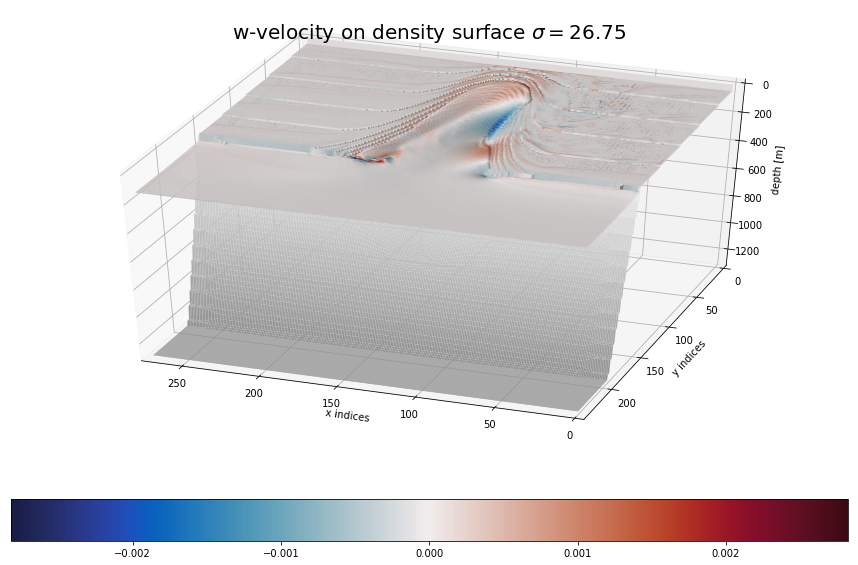

In [16]:
ttl = 'w-velocity'
vm = max([abs(np.nanmin(surf_vovecrtz)), abs(np.nanmax(surf_vovecrtz))])
vmin, vmax = -vm, vm
fig = plot_density_surface(surf_depth, surf_vovecrtz, ideal, density_value, cmo.cm.balance, vmin, vmax, ttl)